In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot

### 1. Define the V1Circuit model

In [2]:
lb = -10.
ub = 10.

sW_P = Parameter("sW_P", 1, lb=lb, ub=0.)
sW_A = Parameter("sW_A", 1, lb=0., ub=ub)

vW_PA = Parameter("vW_PA", 1, lb=lb, ub=0.)
vW_AP = Parameter("vW_AP", 1, lb=lb, ub=0.)

dW_PA = Parameter("dW_PA", 1, lb=0., ub=ub)
dW_AP = Parameter("dW_AP", 1, lb=lb, ub=0.)

hW_P = Parameter("hW_P", 1, lb=lb, ub=ub)
hW_A = Parameter("hW_A", 1, lb=lb, ub=ub)

parameters = [sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A]

model = Model("SC_Circuit", parameters)

In [3]:
import tensorflow as tf
DTYPE = tf.float32

t_cue_delay = 1.2
t_choice = 0.6
t_total = t_cue_delay + t_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

# input parameters
E_constant = 0.
E_Pbias = 0.
E_Prule = 1.
E_Arule = 1.
E_choice = 1.
E_light = 1.
        
# set constant parameters
C = 2

theta = 0.05
beta = 0.5
tau = 0.09
sigma = 0.5

# inputs
I_constant = E_constant * tf.ones((T, 1, 1, 4, 1), dtype=DTYPE)

I_Pbias = np.zeros((T, 4))
I_Pbias[t < T * dt] = np.array([1, 0, 0, 1])
I_Pbias = I_Pbias[:,None,None,:,None]
I_Pbias = E_Pbias * tf.constant(I_Pbias, dtype=DTYPE)

I_Prule = np.zeros((T, 4))
I_Prule[t < 1.2] = np.array([1, 0, 0, 1])
I_Prule = I_Prule[:,None,None,:,None]
I_Prule = E_Prule * tf.constant(I_Prule, dtype=DTYPE)

I_Arule = np.zeros((T, 4))
I_Arule[t < 1.2] = np.array([0, 1, 1, 0])
I_Arule = I_Arule[:,None,None,:,None]
I_Arule = E_Arule * tf.constant(I_Arule, dtype=DTYPE)

I_choice = np.zeros((T, 4))
I_choice[t > 1.2] = np.array([1, 1, 1, 1])
I_choice = I_choice[:,None,None,:,None]
I_choice = E_choice * tf.constant(I_choice, dtype=DTYPE)

I_lightL = np.zeros((T, 4))
I_lightL[1.2 < t] = np.array([1, 1, 0, 0])
#I_lightL[np.logical_and(1.2 < t, t < 1.5)] = np.array([1, 1, 0, 0])
I_lightL = I_lightL[:,None,None,:,None]
I_lightL = E_light * tf.constant(I_lightL, dtype=DTYPE)

I_lightR = np.zeros((T, 4))
I_lightR[1.2 < t] = np.array([0, 0, 1, 1])
#I_lightR[np.logical_and(1.2 < t, t < 1.5)] = np.array([0, 0, 1, 1])
I_lightR = I_lightR[:,None,None,:,None]
I_lightR = E_light * tf.constant(I_lightR, dtype=DTYPE)

I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL
I_LA = I_constant + I_Pbias + I_Arule + I_choice + I_lightL

I = tf.concat((I_LP, I_LA), axis=2)


def SC_sim(sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A):
    N = 10
    Wrow1 = tf.stack([sW_P, vW_PA, dW_PA, hW_P], axis=2)
    Wrow2 = tf.stack([vW_AP, sW_A, hW_A, dW_AP], axis=2)
    Wrow3 = tf.stack([dW_AP, hW_A, sW_A, vW_AP], axis=2)
    Wrow4 = tf.stack([hW_P, dW_PA, vW_PA, sW_P], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,1
    state_shape = (sW_P.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 + 0.05*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    v_t_list = [v]
    u_t_list = [u]
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        #du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * w[i])
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        v_t_list.append(v)
        u_t_list.append(u)

    u_t = tf.stack(u_t_list, axis=0)
    v_t = tf.stack(v_t_list, axis=0)
    return u_t, v_t

def SC_sim_wrap(z):
    sW_P = z[:,0][:,None]
    sW_A = z[:,1][:,None]
    vW_PA = z[:,2][:,None]
    vW_AP = z[:,3][:,None]
    dW_PA = z[:,4][:,None]
    dW_AP = z[:,5][:,None]
    hW_P = z[:,6][:,None]
    hW_A = z[:,7][:,None]
    return SC_sim(sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A)
    

def SC_acc(sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A):
    N = 50
    Wrow1 = tf.stack([sW_P, vW_PA, dW_PA, hW_P], axis=2)
    Wrow2 = tf.stack([vW_AP, sW_A, hW_A, dW_AP], axis=2)
    Wrow3 = tf.stack([dW_AP, hW_A, sW_A, vW_AP], axis=2)
    Wrow4 = tf.stack([hW_P, dW_PA, vW_PA, sW_P], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,N
    state_shape = (sW_P.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 + 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)

    p = tf.reduce_mean(tf.math.sigmoid(100.*(v[:,:,0,:]-v[:,:,3,:])), axis=2)
    return p


In [4]:
model.set_eps(SC_acc)
epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]

data/epi/SC_Circuit/9fcbc34955677a72e5e71f29d9f42b6f/D8_C3_L2_U50_bnmom=9.90E-01_PA_rs1/a9ad8b57aa7cd36cad214c75bb61713c/N100_lr1.00E-03_c0=1.00E+03_gamma2.50E-01_beta5.00E-01


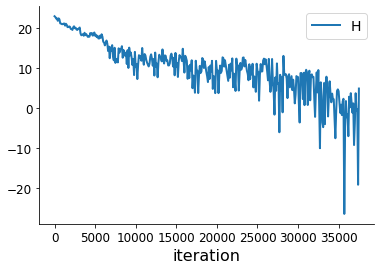

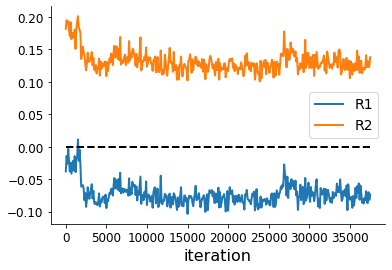

data/epi/SC_Circuit/9fcbc34955677a72e5e71f29d9f42b6f/D8_C3_L2_U50_bnmom=9.90E-01_PA_rs2/a9ad8b57aa7cd36cad214c75bb61713c/N100_lr1.00E-03_c0=1.00E+03_gamma2.50E-01_beta5.00E-01


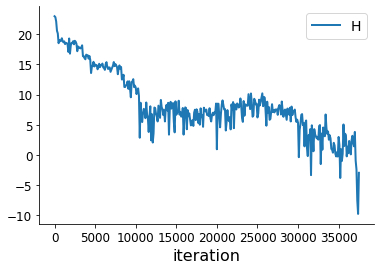

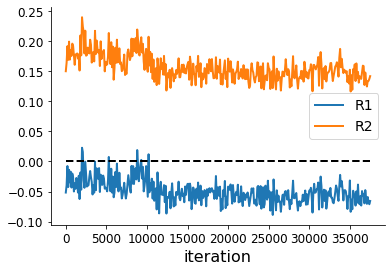

data/epi/SC_Circuit/9fcbc34955677a72e5e71f29d9f42b6f/D8_C3_L2_U50_bnmom=9.90E-01_PA_rs3/a9ad8b57aa7cd36cad214c75bb61713c/N100_lr1.00E-03_c0=1.00E+03_gamma2.50E-01_beta5.00E-01


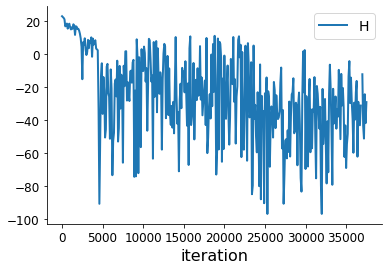

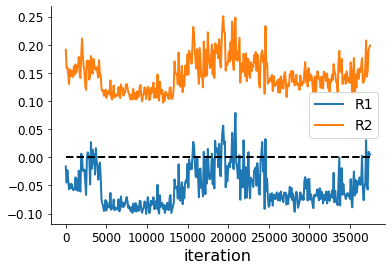

data/epi/SC_Circuit/9fcbc34955677a72e5e71f29d9f42b6f/D8_C3_L2_U50_bnmom=9.90E-01_PA_rs4/a9ad8b57aa7cd36cad214c75bb61713c/N100_lr1.00E-03_c0=1.00E+03_gamma2.50E-01_beta5.00E-01


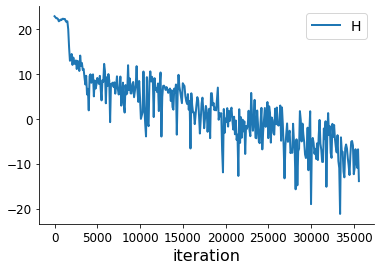

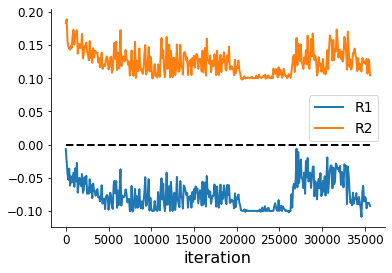

data/epi/SC_Circuit/9fcbc34955677a72e5e71f29d9f42b6f/D8_C3_L2_U50_bnmom=9.90E-01_PA_rs5/a9ad8b57aa7cd36cad214c75bb61713c/N100_lr1.00E-03_c0=1.00E+03_gamma2.50E-01_beta5.00E-01


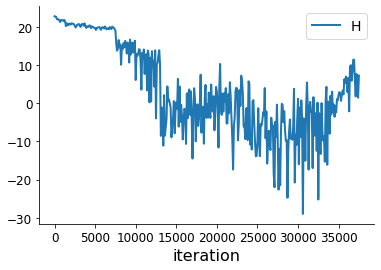

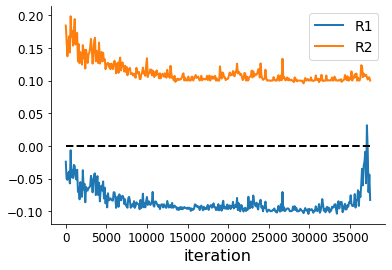

In [6]:
epi_df2 = epi_df[(epi_df['p']==0.6) & (epi_df['c0']==1e3)]


paths = sorted(epi_df2['path'].unique())
for i, path in enumerate(paths):
    print(path)
    epi_df2 = epi_df[epi_df['path'] == path]
    epi_df2.plot('iteration', 'H')
    plt.show()
    Rs = ['R%d' % r for r in range(1,3)]
    epi_df2.plot('iteration', Rs)
    plt.plot([0, epi_df2['iteration'].max()], [0, 0], 'k--')
    #plt.ylim([-1,1])
    plt.show()